# Лабораторная работа №6
## Сикорский М8О-408Б-20
## Вариант 6 (25 по списку)
## Апроксимация первого порядка

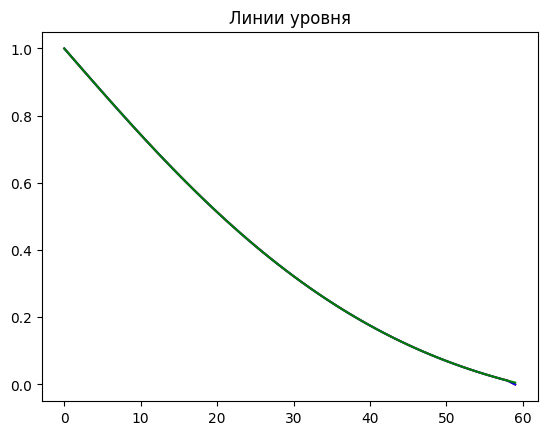

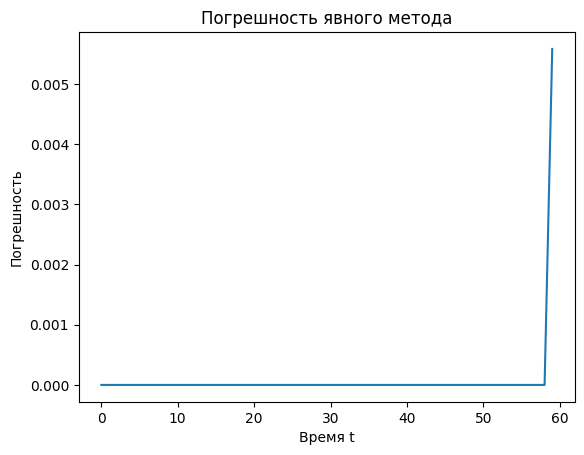

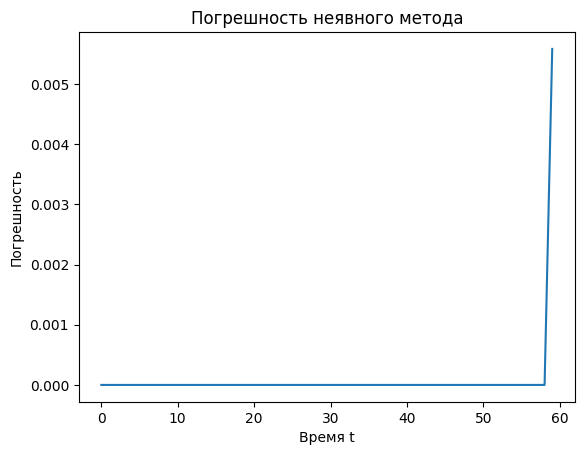

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def tma(a, b, c, d):
    size = len(a)
    p, q, x = [0] * size, [0] * size, [0] * size

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, size):
        denominator = b[i] + a[i] * p[i - 1]
        p[i] = -c[i] / denominator
        q[i] = (d[i] - a[i] * q[i - 1]) / denominator

    x[size - 1] = q[size - 1]

    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

class Parameters:
    def __init__(self, args):
        self.a = args['a']
        self.b = args['b']
        self.c = args['c']
        self.d = args['d']
        self.l = args['l']
        self.f = args['f']
        self.alpha = args['alpha']
        self.beta = args['beta']
        self.gamma = args['gamma']
        self.delta = args['delta']
        self.psi1 = args['psi1']
        self.psi2 = args['psi2']
        self.psi1_dir1 = args['psi1_dir1']
        self.psi1_dir2 = args['psi1_dir2']
        self.phi0 = args['phi0']
        self.phi1 = args['phi1']
        self.bound_type = args['bound_type']
        self.approximation = args['approximation']
        self.solution = args['solution']


class HyperbolicSolver:
    def __init__(self, args, N, K, T):
        self.data = Parameters(args)
        self.h = self.data.l / N
        self.tau = T / K
        self.sigma = (self.tau ** 2) / (self.h ** 2)

    def analyticSolve(self, N, K, T):
        self.h = self.data.l / N
        self.tau = T / K
        self.sigma = (self.tau ** 2) / (self.h ** 2)
        u = np.zeros((K, N))
        for k in range(K):
            for j in range(N):
                u[k][j] = self.data.solution(j * self.h, k * self.tau)        
        return u

    def calculate(self, N, K):
        u = np.zeros((K, N))

        for j in range(0, N - 1):
            x = j * self.h
            u[0][j] = self.data.psi1(x)

            psi2_term = self.data.psi2(x) * self.tau
            psi1_dir2_term = self.data.psi1_dir2(x) * (self.tau ** 2 / 2)

            if self.data.approximation == 'p1':
                u[1][j] = self.data.psi1(x) + psi2_term + psi1_dir2_term
            elif self.data.approximation == 'p2':
                psi1_dir2_term += self.data.b * self.data.psi1_dir1(x) + \
                                  self.data.c * self.data.psi1(x) + self.data.f()
                u[1][j] = self.data.psi1(x) + psi2_term + psi1_dir2_term * (self.tau ** 2 / 2)

        return u


    def implicit_solver(self, N, K, T):
        u = self.calculate(N, K)
        a, b, c, d = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
        for k in range(2, K):
            for j in range(1, N):
                a[j], b[j], c[j], d[j] = self.sigma, -(1 + 2 * self.sigma), self.sigma, -2 * u[k - 1][j] + u[k - 2][j]
    
            if self.data.bound_type == 'a1p2':
                b[0], c[0], d[0] = self.data.alpha / self.h / (self.data.beta - self.data.alpha / self.h), 1, \
                                   1 / (self.data.beta - self.data.alpha / self.h) * self.data.phi0(k * self.tau)
                a[-1], d[-1] = -self.data.gamma / self.h / (self.data.delta + self.data.gamma / self.h), \
                               1 / (self.data.delta + self.data.gamma / self.h) * self.data.phi1(k * self.tau)
    
            elif self.data.bound_type == 'a2p3':
                k1, omega, xi = 2 * self.h * self.data.beta - 3 * self.data.alpha, self.tau ** 2 * self.data.b / (
                            2 * self.h), self.data.d * self.tau / 2
                b[0], c[0], d[0] = 4 * self.data.alpha - self.data.alpha / (self.sigma + omega) * (
                            1 + xi + 2 * self.sigma - self.data.c * self.tau ** 2), \
                                   k1 - self.data.alpha * (omega - self.sigma) / (omega + self.sigma), \
                                   2 * self.h * self.data.phi0(k * self.tau) + self.data.alpha * d[1] / (
                                               -self.sigma - omega)
                a[-1], d[-1] = -self.data.gamma / (omega - self.sigma) * (
                            1 + xi + 2 * self.sigma - self.data.c * self.tau ** 2) - 4 * self.data.gamma, \
                               2 * self.h * self.data.phi1(k * self.tau) - self.data.gamma * d[-2] / (omega - self.sigma)
    
            elif self.data.bound_type == 'a2p2':
                b[0], c[0], d[0] = 2 * self.data.a / self.h, -2 * self.data.a / self.h + self.h / self.tau ** 2 - \
                                   self.data.c * self.h - self.data.d * self.h / (2 * self.tau) + \
                                   self.data.beta / self.data.alpha * (2 * self.data.a + self.data.b * self.h), \
                                   self.h / self.tau ** 2 * (u[k - 2][0] - 2 * u[k - 1][0]) - self.h * self.data.f() + \
                                   -self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + \
                                   (2 * self.data.a - self.data.b * self.h) / self.data.alpha * self.data.phi0(
                                       k * self.tau)
                a[-1], d[-1] = -b[0], self.h / self.tau ** 2 * (-u[k - 2][0] + 2 * u[k - 1][0]) + self.h * self.data.f() + \
                               self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + \
                               (2 * self.data.a + self.data.b * self.h) / self.data.alpha * self.data.phi1(k * self.tau)
    
            u[k] = tma(a, b, c, d)
    
        return u


    def _left_bound_a1p2(self, u, k, t):
        coeff = self.data.alpha / self.h
        return (-coeff * u[k - 1][1] + self.data.phi0(t)) / (self.data.beta - coeff)

    def _right_bound_a1p2(self, u, k, t):
        coeff = self.data.gamma / self.h
        return (coeff * u[k - 1][-2] + self.data.phi1(t)) / (self.data.delta + coeff)

    def _left_bound_a2p2(self, u, k, t):
        n = self.data.c * self.h - 2 * self.data.a / self.h - self.h / self.tau ** 2 - self.data.d * self.h / \
            (2 * self.tau) + self.data.beta / self.data.alpha * (2 * self.data.a - self.data.b * self.h)
        return 1 / n * (- 2 * self.data.a / self.h * u[k][1] +
                        self.h / self.tau ** 2 * (u[k - 2][0] - 2 * u[k - 1][0]) +
                        -self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + -self.h * self.data.f() +
                        (2 * self.data.a - self.data.b * self.h) / self.data.alpha * self.data.phi0(t))

    def _right_bound_a2p2(self, u, k, t):
        n = -self.data.c * self.h + 2 * self.data.a / self.h + self.h / self.tau ** 2 + self.data.d * self.h / \
            (2 * self.tau) + self.data.delta / self.data.gamma * (2 * self.data.a + self.data.b * self.h)
        return 1 / n * (2 * self.data.a / self.h * u[k][-2] +
                        self.h / self.tau ** 2 * (2 * u[k - 1][-1] - u[k - 2][-1]) +
                        self.data.d * self.h / (2 * self.tau) * u[k - 2][-1] + self.h * self.data.f() +
                        (2 * self.data.a + self.data.b * self.h) / self.data.gamma * self.data.phi1(t))

    def _left_bound_a2p3(self, u, k, t):
        denom = 2 * self.h * self.data.beta - 3 * self.data.alpha
        return self.data.alpha / denom * u[k - 1][2] - 4 * self.data.alpha / denom * u[k - 1][1] + \
               2 * self.h / denom * self.data.phi0(t)

    def _right_bound_a2p3(self, u, k, t):
        denom = 2 * self.h * self.data.delta + 3 * self.data.gamma
        return 4 * self.data.gamma / denom * u[k - 1][-2] - self.data.gamma / denom * u[k - 1][-3] + \
               2 * self.h / denom * self.data.phi1(t)

    def _get_bound_functions(self):
        if self.data.bound_type == 'a1p2':
            return self._left_bound_a1p2, self._right_bound_a1p2
        elif self.data.bound_type == 'a2p2':
            return self._left_bound_a2p2, self._right_bound_a2p2
        elif self.data.bound_type == 'a2p3':
            return self._left_bound_a2p3, self._right_bound_a2p3
        
        
    def explicit_solver(self, N, K, T):
        u = self.calculate(N, K)
    
        left_bound, right_bound = self._get_bound_functions()
    
        for k in range(2, K):
            t = k * self.tau
            for j in range(1, N - 1):
                quadr = self.tau ** 2
                tmp1 = self.sigma + self.data.b * quadr / (2 * self.h)
                tmp2 = self.sigma - self.data.b * quadr / (2 * self.h)
                u[k][j] = u[k - 1][j + 1] * tmp1 + \
                           u[k - 1][j] * (-2 * self.sigma + 2 + self.data.c * quadr) + \
                           u[k - 1][j - 1] * tmp2 - u[k - 2][j] + quadr * self.data.f()
            u[k][0] = left_bound(u, k, t)
            u[k][-1] = right_bound(u, k, t)
    
        return u

def plot_lines(title, lines_dict, time, labels=None):
    fig, ax = plt.subplots()
    ax.set_title(title)

    for key, color in zip(lines_dict.keys(), ['r', 'b', 'g']):
        ax.plot(lines_dict[key][time], color=color, label=key)

def plot_error(title, data, analytic_data):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(abs(data - analytic_data))
    ax.set_ylabel('Погрешность')
    ax.set_xlabel('Время t')
    plt.show()

def presentation(dict_, time=0):
    plot_lines('Линии уровня', dict_, time)
    plot_error('Погрешность явного метода', dict_['explicit'][time], dict_['analytic'][time])
    plot_error('Погрешность неявного метода', dict_['implicit'][time], dict_['analytic'][time])


data = {'N': 60, 'K': 100, 'T': 1}
N, K, T = int(data['N']), int(data['K']), int(data['T'])

args = {
    'a': 1,
    'b': 2,
    'c': -2,
    'd': 0,
    'l': np.pi / 2,
    'f': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'psi1': lambda x: np.exp(-x) * np.cos(x),
    'psi2': lambda x: 0,
    'psi1_dir1': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'psi1_dir2': lambda x: 2 * np.exp(-x) * np.sin(x),
    'phi0': lambda t: np.cos(2 * t),
    'phi1': lambda t: 0,
    'bound_type': 'a1p2',
    'approximation': 'p1',
    'solution': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
}

solver = HyperbolicSolver(args, N, K, T)

lines = {
    'implicit': solver.implicit_solver(N, K, T),
    'explicit': solver.explicit_solver(N, K, T),
    'analytic': solver.analyticSolve(N, K, T)
}

presentation(lines)

## Апроксимация 3-х точечная второго порядка

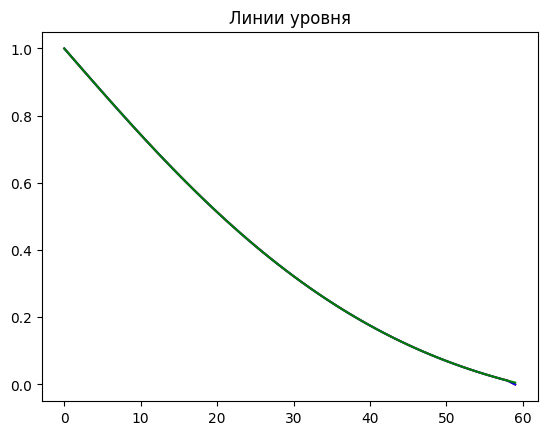

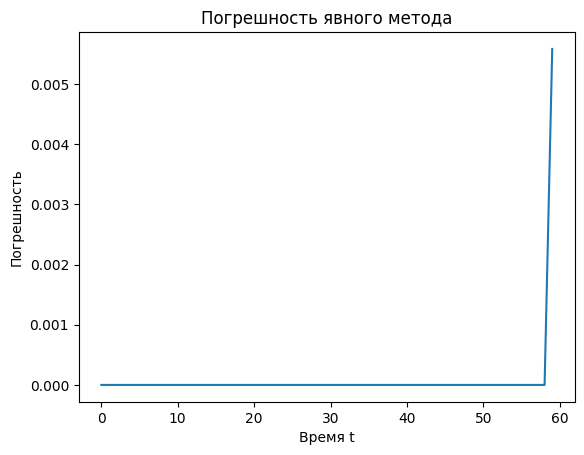

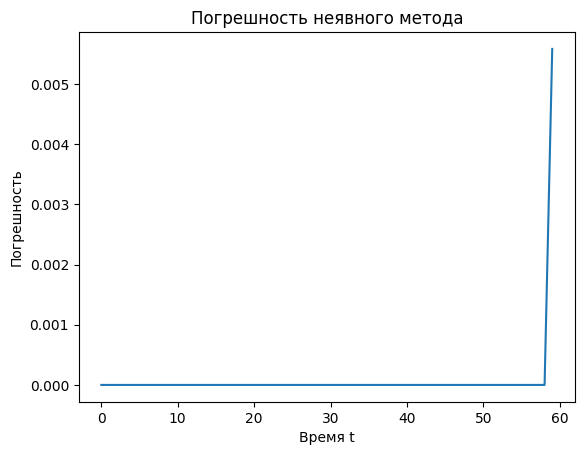

In [66]:
data = {'N': 60, 'K': 100, 'T': 1}
N, K, T = int(data['N']), int(data['K']), int(data['T'])

args = {
    'a': 1,
    'b': 2,
    'c': -2,
    'd': 0,
    'l': np.pi / 2,
    'f': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'psi1': lambda x: np.exp(-x) * np.cos(x),
    'psi2': lambda x: 0,
    'psi1_dir1': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'psi1_dir2': lambda x: 2 * np.exp(-x) * np.sin(x),
    'phi0': lambda t: np.cos(2 * t),
    'phi1': lambda t: 0,
    'bound_type': 'a2p3',
    'approximation': 'p2',
    'solution': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
}

solver = HyperbolicSolver(args, N, K, T)

lines = {
    'implicit': solver.implicit_solver(N, K, T),
    'explicit': solver.explicit_solver(N, K, T),
    'analytic': solver.analyticSolve(N, K, T)
}

presentation(lines)

## Двухточечная апроксимация второго порядка

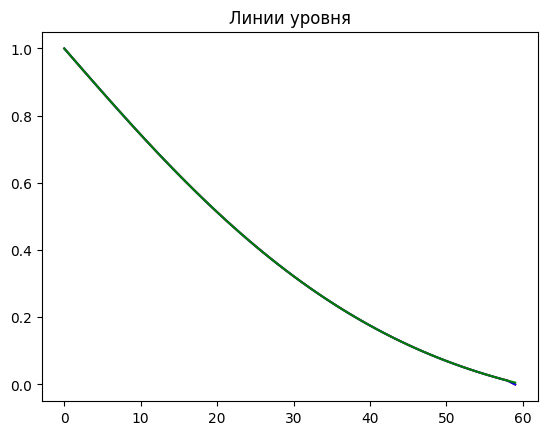

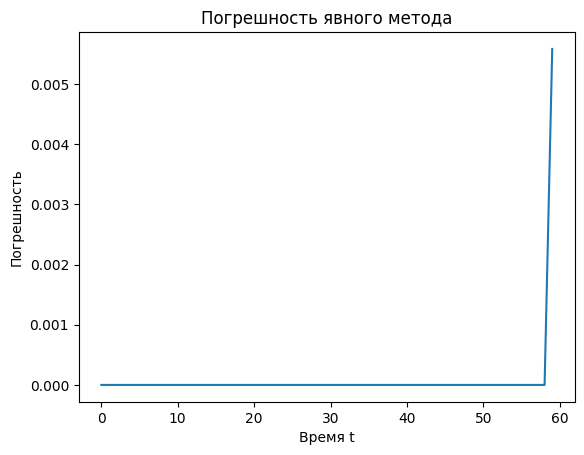

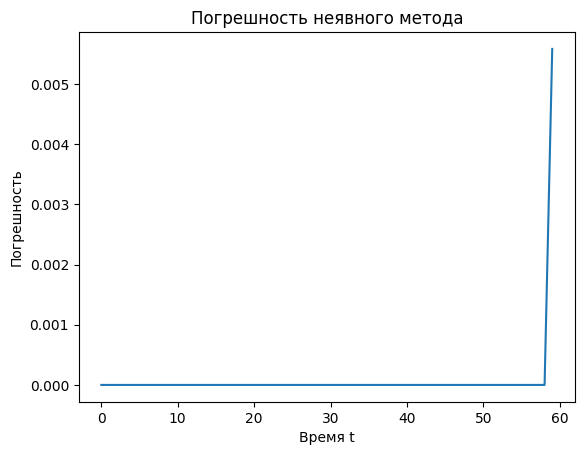

In [67]:
data = {'N': 60, 'K': 100, 'T': 1}
N, K, T = int(data['N']), int(data['K']), int(data['T'])

args = {
    'a': 1,
    'b': 2,
    'c': -2,
    'd': 0,
    'l': np.pi / 2,
    'f': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'psi1': lambda x: np.exp(-x) * np.cos(x),
    'psi2': lambda x: 0,
    'psi1_dir1': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'psi1_dir2': lambda x: 2 * np.exp(-x) * np.sin(x),
    'phi0': lambda t: np.cos(2 * t),
    'phi1': lambda t: 0,
    'bound_type': 'a1p2',
    'approximation': 'p2',
    'solution': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
}

solver = HyperbolicSolver(args, N, K, T)

lines = {
    'implicit': solver.implicit_solver(N, K, T),
    'explicit': solver.explicit_solver(N, K, T),
    'analytic': solver.analyticSolve(N, K, T)
}

presentation(lines)

## Как погрешность зависит от сеточных параметров

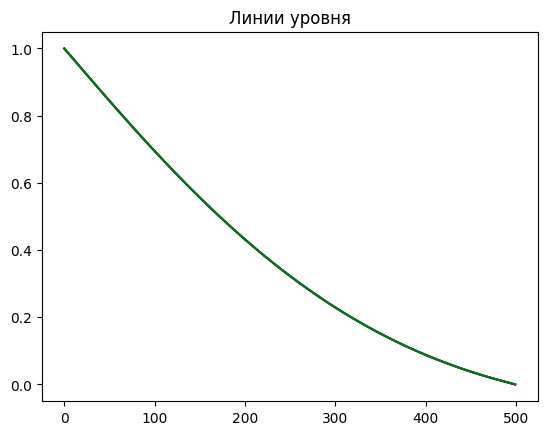

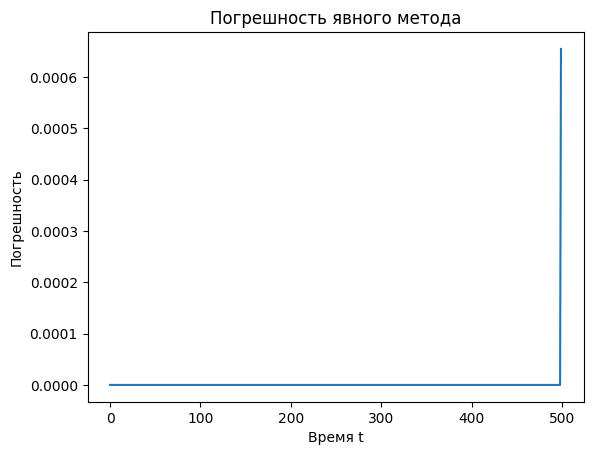

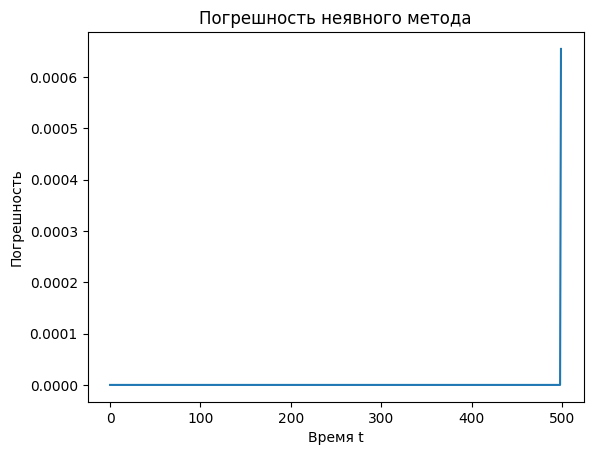

In [68]:
data = {'N': 500, 'K': 150, 'T': 1}
N, K, T = int(data['N']), int(data['K']), int(data['T'])

args = {
    'a': 1,
    'b': 2,
    'c': -2,
    'd': 0,
    'l': np.pi / 2,
    'f': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'psi1': lambda x: np.exp(-x) * np.cos(x),
    'psi2': lambda x: 0,
    'psi1_dir1': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'psi1_dir2': lambda x: 2 * np.exp(-x) * np.sin(x),
    'phi0': lambda t: np.cos(2 * t),
    'phi1': lambda t: 0,
    'bound_type': 'a1p2',
    'approximation': 'p1',
    'solution': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
}

solver = HyperbolicSolver(args, N, K, T)

lines = {
    'implicit': solver.implicit_solver(N, K, T),
    'explicit': solver.explicit_solver(N, K, T),
    'analytic': solver.analyticSolve(N, K, T)
}

presentation(lines)

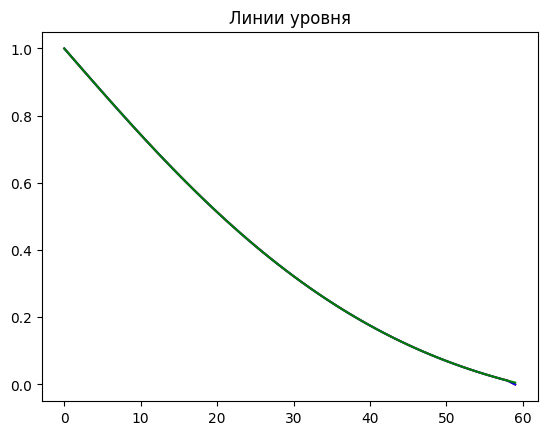

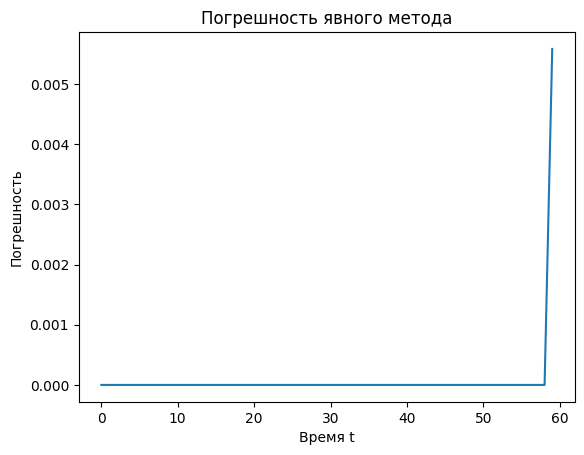

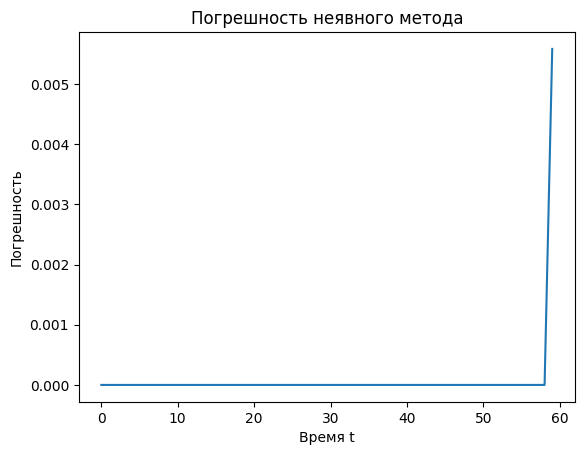

In [69]:
data = {'N': 60, 'K': 10000, 'T': 1}
N, K, T = int(data['N']), int(data['K']), int(data['T'])

args = {
    'a': 1,
    'b': 2,
    'c': -2,
    'd': 0,
    'l': np.pi / 2,
    'f': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'psi1': lambda x: np.exp(-x) * np.cos(x),
    'psi2': lambda x: 0,
    'psi1_dir1': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'psi1_dir2': lambda x: 2 * np.exp(-x) * np.sin(x),
    'phi0': lambda t: np.cos(2 * t),
    'phi1': lambda t: 0,
    'bound_type': 'a1p2',
    'approximation': 'p1',
    'solution': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
}

solver = HyperbolicSolver(args, N, K, T)

lines = {
    'implicit': solver.implicit_solver(N, K, T),
    'explicit': solver.explicit_solver(N, K, T),
    'analytic': solver.analyticSolve(N, K, T)
}

presentation(lines)

## Вывод по лабораторной работе:
В процессе решения лабораторной работы стало видно, что шаг сетки h оказывает значительное влияние на вычисление погрешности. Уменьшив его, получилось уменьшить погрешность линейно, что подчеркивает чувствительность результата к выбору этого параметра. Однако, интересным является тот факт, что уменьшение шага времени tau на порядок не оказало существенного влияния на мои результаты. Это может свидетельствовать о том, что для данной задачи величина шага по времени не так критична, как шаг по пространству, и возможно, оптимизация по времени не требуется для достижения приемлемой точности